- [Balanced sampling between classes with torchvision dataloader](https://discuss.pytorch.org/t/balanced-sampling-between-classes-with-torchvision-dataloader/2703)
- [Imbalanced dataset sampler](https://www.kaggle.com/doanquanvietnamca/imbalanced-dataset-sampler)
- [Survey of resampling techniques for improving classification performance in unbalanced datasets](https://arxiv.org/abs/1608.06048)
- [How to deal with Imbalanced Datasets in PyTorch - Weighted Random Sampler Tutorial](https://www.youtube.com/watch?v=4JFVhJyTZ44)
- [Augment the minority class only in an imbalanced dataset](https://discuss.pytorch.org/t/how-to-augment-the-minority-class-only-in-an-unbalanced-dataset/13797/4)
- [Practical tips for class imbalance in binary classification](https://radiant-brushlands-42789.herokuapp.com/towardsdatascience.com/practical-tips-for-class-imbalance-in-binary-classification-6ee29bcdb8a7)

In [1]:
#@title Mount Google Drive
from google.colab import drive
drive.mount('/content/drive/')
project_path = '/content/drive/MyDrive/Thesis/'
print(f'Currently at {project_path}')

Mounted at /content/drive/
Currently at /content/drive/MyDrive/Thesis/


In [2]:
#@title Install modules
!pip install -q -U albumentations
!pip install -q pretrainedmodels
!pip install -q bayesian-optimization
#!pip show albumentations

     |████████████████████████████████| 98 kB 3.1 MB/s 
     |████████████████████████████████| 37.1 MB 44 kB/s 
     |████████████████████████████████| 58 kB 3.1 MB/s 


In [3]:
#@title Importing & Initialization
# Import modules
import sys
sys.path.append(project_path)
import logging
#%load_ext tensorboard
import torch
import albumentations as A
# Import custom modules
import modules.model
import modules.training
import modules.dsets
import modules.logconf
import modules.testlog
import modules.visualize
import modules.finetune
import modules.evaluation

# Initialize logger
logger = logging.getLogger(__name__)
modules.logconf.initLogger(logger = logger, project_path=project_path)
logger.debug('#'*20 + ' Starting new session ' + '#'*20)

2021-09-05 03:48:53,339 - __main__ - initLogger - DEBUG - [CMPL] Initialized logger
2021-09-05 03:48:53,896 - __main__ - <module> - DEBUG - #################### Starting new session ####################


In [4]:
#@title Hyperparameters & Stopping conditions
# Fixed
num_workers = 0
num_trials = 100
num_folds = 5
num_epochs_finetune = 10
num_epochs_training = 20
threshold = 0.5

# Fine-tuning
learning_rate = 1e-3    
                        # 1e-2 .. 1e-4
momentum = 0.9          # 0.5 .. 0.99
batch_size = 16         # 8 16 32 64 
weight_decay = 0.01     # 0.001 .. 0.1
                        # pct_start = 0.3 .. 0.5 linear


# Stopping conditions
stop_metric = 'auprc'
strip_len = 5
cooldown = 0.95
patience = 3
latency = 5
GL_stop = 0
NGL_stop = 3
SI_stop = 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = torch.nn.CrossEntropyLoss(reduction = 'sum', weight = torch.tensor([1., 1.]).to(device))

In [161]:
#@title Reload custom modules (debugging)
from importlib import reload

logger.debug('[CMPL] Reload modules')
modules.model = reload(modules.model)
modules.training = reload(modules.training)
modules.dsets = reload(modules.dsets)
modules.logconf = reload(modules.logconf)
modules.testlog = reload(modules.testlog)
modules.visualize = reload(modules.visualize)
modules.finetune = reload(modules.finetune)
modules.evaluation = reload(modules.evaluation)

modelClass = modules.model.ModelClass(project_path = project_path)
trainingClass = modules.training.TrainingClass(project_path = project_path,
                                               num_workers = num_workers,
                                               criterion = criterion,
                                               num_epochs = num_epochs_training,
                                               threshold = threshold,
                                               stop_metric = stop_metric,
                                               strip_len = strip_len,
                                               cooldown = cooldown,
                                               patience = patience,
                                               latency = latency,
                                               GL_stop = GL_stop,
                                               NGL_stop = NGL_stop,
                                               SI_stop = SI_stop)
datasetClass = modules.dsets.DatasetClass(project_path = project_path,
                                          batch_size = batch_size,
                                          num_workers = num_workers,
                                          folder = 'thesis')
visualizeClass = modules.visualize.VisualizeClass(project_path = project_path)
finetuneClass = modules.finetune.FinetuneClass(project_path = project_path,
                                               num_workers = num_workers,
                                               criterion = criterion,
                                               num_trials = num_trials,
                                               num_folds = num_folds,
                                               num_epochs = num_epochs_finetune)
evaluationClass = modules.evaluation.EvaluationClass(project_path = project_path)

2021-09-05 05:27:12,466 - __main__ - <module> - DEBUG - [CMPL] Reload modules
2021-09-05 05:27:12,834 - modules.model - __init__ - INFO - Using cuda device.
2021-09-05 05:27:12,835 - modules.model - __init__ - DEBUG - [CMPL] Initialized ModelClass - fix 14
2021-09-05 05:27:12,841 - modules.training - __init__ - INFO - Non-tunable hyperparameters: num_workers = 0, criterion = CrossEntropyLoss(), num_epochs = 20, threshold = {'ResNet50': 0.0031, 'NASNet_A_Mobile': 0.0265, 'Xception': 0.00667}
2021-09-05 05:27:12,845 - modules.training - __init__ - INFO - Stopping conditions: stop_metric = auprc, strip_len = 5, cooldown = 0.95, patience = 3, latency = 5, GL_stop = 0, NGL_stop = 3, SI_stop = 3
2021-09-05 05:27:12,850 - modules.training - __init__ - INFO - Using cuda device.
2021-09-05 05:27:12,855 - modules.training - __init__ - DEBUG - [CMPL] Initialized TrainingClass - fix 220
2021-09-05 05:27:12,861 - modules.dsets - __init__ - INFO - Hyperparameters: batch_size = 16, num_workers = 0
20

In [162]:
#@title Load datasets
train_set   = datasetClass.loadDataset(subset = 'train')
val_set     = datasetClass.loadDataset(subset = 'val')
test_set    = datasetClass.loadDataset(subset = 'test')

train_set.getClassDistribution(), val_set.getClassDistribution(), test_set.getClassDistribution()

2021-09-05 05:27:21,652 - modules.dsets - loadDataset - DEBUG - Loading dataset...
2021-09-05 05:27:21,657 - modules.dsets - initTransform - DEBUG - [CMPL] Initialized normalized transforms
2021-09-05 05:27:21,685 - modules.dsets - __init__ - INFO - [CMPL] Loaded train subset
2021-09-05 05:27:21,687 - modules.dsets - loadDataset - DEBUG - Loading dataset...
2021-09-05 05:27:21,692 - modules.dsets - initTransform - DEBUG - [CMPL] Initialized normalized transforms
2021-09-05 05:27:21,705 - modules.dsets - __init__ - INFO - [CMPL] Loaded val subset
2021-09-05 05:27:21,708 - modules.dsets - loadDataset - DEBUG - Loading dataset...
2021-09-05 05:27:21,711 - modules.dsets - initTransform - DEBUG - [CMPL] Initialized normalized transforms
2021-09-05 05:27:21,772 - modules.dsets - __init__ - INFO - [CMPL] Loaded test subset


([1600, 67], [400, 17], [3000, 100])

In [ ]:
#@title Finetune
for _ in range(1):
    !nvidia-smi
    hparams, target, cp_trial, new_cv_flag = finetuneClass.finetune(modelClass = modelClass,
                                                                    model_name = 'NASNet_A_Mobile', #@param {type:"string"}
                                                                    train_set = train_set)

In [ ]:
#@title View data
import matplotlib.pyplot as plt
tunable_hparam_names = ['batch_size', 'max_lr', 'ratio_lr', 'max_momentum', 'base_momentum', 'weight_decay']
model_name = 'Xception' #@param {type:"string"}

def printHparams(hparams, trial):
    string = ''
    string += f'{trial}\t'
    string += f'{target[trial]:.3f}\t'
    for hparam in tunable_hparam_names:
        if hparam == 'batch_size':
            string += f'{hparams[hparam][trial]}\t'
        else:
            string += f'{hparams[hparam][trial]:.2e}\t'
    print(string)

hparams, target, _, _ = finetuneClass.loadBayesian(model_name = model_name)
metrics, cp_trial, cp_fold, cp_epoch = finetuneClass.loadMetrics(model_name = model_name)

cp_trial_for_plot = cp_trial

print()
# Limit to cp_trial
for hparam in tunable_hparam_names:
    hparams[hparam] = hparams[hparam][0:cp_trial + 1]
target = target[0:cp_trial + 1]

# print('All trials')
# print('trial\ttarget\tbatch_s\tmax_lr\t\tratio_lr\tmax_momentum\tbase_momentum\tweight_decay')
# target_sort, target_sort_ind = target.sort()
# for trial in target_sort_ind:
#   printHparams(hparams, trial)

# hparams of Max target
quantile = torch.tensor([0.25, 0.5, 0.75])
Q = torch.quantile(target, quantile, dim=0, keepdim=True)
IQR = Q[2] - Q[0]
low_lim = Q[0] - 1.5*IQR
high_lim = Q[2] + 1.5*IQR

high_target_bool =  (target >= low_lim)
high_target_ind = torch.arange(target.size()[0])[high_target_bool]

low_target_bool =  (target < low_lim)
low_target_ind = torch.arange(target.size()[0])[low_target_bool]

print()
print(f'Interquatile ranges = {Q.squeeze()}, Q[1] - Q[0] = {Q[1] - Q[0]}')
print(f'hparams of low targets: {low_target_ind.size()[0]} trials < {low_lim}')
print('trial\ttarget\tbatch_s\tmax_lr\t\tratio_lr\tmax_momentum\tbase_momentum\tweight_decay')
for trial in low_target_ind:
    printHparams(hparams, trial)

# Plot
fig, ax = plt.subplots(10, 5, figsize = (20, 10))
for trial in range(cp_trial + 1):
    for fold in range(num_folds):
        ax[(trial // 5, trial % 5)].plot(metrics['cv_val']['auprc'][trial, fold])
        ax[(trial // 5, trial % 5)].set_ylim(bottom = -0.05, top = 1.05)
        ax[(trial // 5, trial % 5)].text(x = num_epochs_finetune - 1,
                                         y = 0,
                                         s = f'trial {trial}',
                                         ha = 'right',
                                         va = 'bottom')

In [ ]:
#@title Pearson product-moment correlation coefficients
import numpy as np
norm_hparams = {}
for hparam in tunable_hparam_names:
    norm_hparams['batch_size'] = torch.log2(hparams['batch_size']).type(torch.ShortTensor)
    norm_hparams['max_lr'] = torch.log10(hparams['max_lr'])
    norm_hparams['ratio_lr'] = torch.log10(hparams['ratio_lr'])
    norm_hparams['max_momentum'] = hparams['max_momentum']
    norm_hparams['base_momentum'] = hparams['base_momentum']
    norm_hparams['weight_decay'] = torch.log10(hparams['weight_decay'])

target_and_norm_hparams = torch.cat([target.unsqueeze(dim = 0),
                                     norm_hparams['batch_size'].unsqueeze(dim = 0),
                                     norm_hparams['max_lr'].unsqueeze(dim = 0),
                                     norm_hparams['ratio_lr'].unsqueeze(dim = 0),
                                     norm_hparams['max_momentum'].unsqueeze(dim = 0),
                                     norm_hparams['base_momentum'].unsqueeze(dim = 0),
                                     norm_hparams['weight_decay'].unsqueeze(dim = 0),
                                     ],
                                    dim = 0)

#print(target_and_norm_hparams)
np.set_printoptions(threshold=64, precision = 4)
print(np.corrcoef(target_and_norm_hparams))

In [ ]:
#@title Filter out trials
low_target = target[low_target_ind]
high_target = target[high_target_ind]

low_hparams = {}
high_hparams = {}
for hparam in tunable_hparam_names:
    low_hparams[hparam] = hparams[hparam][low_target_ind]
    high_hparams[hparam] = hparams[hparam][high_target_ind]

In [ ]:
#@title visualizeFinetune
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
##################################################
# Init
##################################################

fig, ax = plt.subplots(2, 3, figsize = (15, 8), sharey='row')
# Share y-axis
ax[0, 0].set_ylabel('AU-PRC', fontsize = 15)
ax[1, 0].set_ylabel('AU-PRC', fontsize = 15)
ax[0, 0].set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax[1, 0].set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
# Suptitlte
fig.suptitle(t = f'Hyperparameter tuning of {model_name}: AU-PRC score vs. each hyperparameter', x = 0.5, y = 1.07,
             ha = 'center', va = 'bottom', fontsize = 20)
bounds = {}
num_bars = {}

low_mean = {}
low_std = {}
low_frequency = {}
high_mean = {}
high_std = {}
high_frequency = {}

pbounds = {
    'batch_size'   : (3, 6),
    'max_lr'       : (-4, -2),
    'ratio_lr'     : (-2, 0),
    'max_momentum' : (0.85, 0.95),
    'base_momentum': (0.75, 0.85),
    'weight_decay' : (-3, -1)
}
hparam_2_ax = {
    'batch_size': (0, 0),
    'max_lr': (0, 1),
    'ratio_lr': (0, 2),
    'max_momentum': (1, 1),
    'base_momentum': (1, 2),
    'weight_decay': (1, 0)
}
hparam_2_label = {
    'batch_size': 'Batch size',
    'max_lr': 'Max learning rate (LR)',
    'ratio_lr': 'Ratio of base LR/max LR',
    'max_momentum': 'Max momentum',
    'base_momentum': 'Base momentum',
    'weight_decay': 'Weight decay'
}

# Data & Plotting Will be looped for each hparam
for hparam in tunable_hparam_names:
    ##################################################
    # Data
    ##################################################
    # num_bars, bounds
    if hparam == 'batch_size':
        num_bars[hparam] = 4
        bounds[hparam] = torch.logspace(start = pbounds[hparam][0], end = pbounds[hparam][1], steps = num_bars[hparam], base = 2).round().type(torch.LongTensor)
    elif hparam in ['max_lr', 'ratio_lr', 'weight_decay', 'max_momentum', 'base_momentum']:
        num_bars[hparam] = 6
        if hparam in ['max_lr', 'ratio_lr', 'weight_decay']:
            bounds[hparam] = torch.logspace(start = pbounds[hparam][0], end = pbounds[hparam][1], steps = num_bars[hparam] + 1, base = 10)
        elif hparam in ['max_momentum', 'base_momentum']:
            bounds[hparam] = torch.linspace(start = pbounds[hparam][0], end = pbounds[hparam][1], steps = num_bars[hparam] + 1)
        bounds[hparam][-1] += 1e-7

    # bar_trials, target_mean, target_std
    low_num_trials = low_target.size()[0] - 1
    low_bar_trials = torch.zeros(num_bars[hparam], low_num_trials + 1).type(torch.bool)
    low_mean[hparam] = torch.zeros(num_bars[hparam])
    low_std[hparam] = torch.zeros(num_bars[hparam])

    high_num_trials = high_target.size()[0] - 1
    high_bar_trials = torch.zeros(num_bars[hparam], high_num_trials + 1).type(torch.bool)
    high_mean[hparam] = torch.zeros(num_bars[hparam])
    high_std[hparam] = torch.zeros(num_bars[hparam])
    
    for bar_ind in range(num_bars[hparam]):
        if hparam == 'batch_size':
            low_bar_trials[bar_ind] = (low_hparams[hparam] == bounds[hparam][bar_ind])
            high_bar_trials[bar_ind] = (high_hparams[hparam] == bounds[hparam][bar_ind])
        elif hparam in ['max_lr', 'ratio_lr', 'weight_decay', 'max_momentum', 'base_momentum']:
            low_bar_trials[bar_ind] = (bounds[hparam][bar_ind] <= low_hparams[hparam]) & (low_hparams[hparam] < bounds[hparam][bar_ind + 1])
            high_bar_trials[bar_ind] = (bounds[hparam][bar_ind] <= high_hparams[hparam]) & (high_hparams[hparam] < bounds[hparam][bar_ind + 1])

        low_mean[hparam][bar_ind]   = low_target[low_bar_trials[bar_ind]].mean(dim = 0)
        low_std[hparam][bar_ind]    = low_target[low_bar_trials[bar_ind]].std(dim = 0)
        high_mean[hparam][bar_ind]   = high_target[high_bar_trials[bar_ind]].mean(dim = 0)
        high_std[hparam][bar_ind]    = high_target[high_bar_trials[bar_ind]].std(dim = 0)

    # frequency
    low_frequency[hparam] = low_bar_trials.sum(dim = 1)
    high_frequency[hparam] = high_bar_trials.sum(dim = 1)

    x = bounds[hparam]
    low_y = low_mean[hparam]
    low_y_err = low_std[hparam]
    low_alpha = low_frequency[hparam]/low_frequency[hparam].max()

    high_y = high_mean[hparam]
    high_y_err = high_std[hparam]
    high_alpha = high_frequency[hparam]/high_frequency[hparam].max()

    ##################################################
    # Plotting
    ##################################################
    ax[hparam_2_ax[hparam]].set_xlabel(hparam_2_label[hparam], fontsize = 15)
    ax[hparam_2_ax[hparam]].set_ylim(bottom = -0.25, top = 1.25)
    ax[hparam_2_ax[hparam]].axhline(y = low_lim,
                                    color = 'black',
                                    linestyle = 'dashed')
    ax[hparam_2_ax[hparam]].axhline(y = 0,
                                    color = 'black',
                                    linewidth = 1)
    ax[hparam_2_ax[hparam]].axhline(y = 1,
                                    color = 'black',
                                    linewidth = 1)

    if hparam in ['max_momentum', 'base_momentum']:
        ax[hparam_2_ax[hparam]].set_xticks(bounds[hparam])
    elif hparam in ['batch_size', 'max_lr', 'ratio_lr', 'weight_decay']:
        ax[hparam_2_ax[hparam]].set_xscale('log')

    if hparam == 'batch_size':
        width = 0.45
        ax[hparam_2_ax[hparam]].set_xticks(bounds[hparam])
        ax[hparam_2_ax[hparam]].set_xticklabels(bounds[hparam].tolist())
        for i in range(num_bars[hparam]):
            ax[hparam_2_ax[hparam]].fill([x[i] / 2**(width), x[i] / 2**(width), x[i] * 2**(width), x[i] * 2**(width)],
                                         [high_y[i] - high_y_err[i], 1, 1, high_y[i] - high_y_err[i]], #high_y[i] + high_y_err[i]
                                         color = 'white')
            ax[hparam_2_ax[hparam]].plot([x[i] / 2**(width), x[i] * 2**(width)], [low_y[i], low_y[i]],
                                         color = 'darkblue', alpha = low_alpha[i].item(),
                                         linewidth = 3)
            ax[hparam_2_ax[hparam]].plot([x[i] / 2**(width), x[i] * 2**(width)], [high_y[i], high_y[i]],
                                         color = 'darkorange', alpha = high_alpha[i].item(),
                                         linewidth = 3)

            if not low_y[i].isnan():
                ax[hparam_2_ax[hparam]].text(s = f'{low_mean[hparam][i]:.3f}',
                                             fontsize = 12, color = 'darkblue', weight = 'semibold',
                                             x = x[i], y = -0.05,
                                             va ='top', ha = 'center')
                ax[hparam_2_ax[hparam]].text(s = f'({low_frequency[hparam][i]}x)',
                                             fontsize = 12, color = 'darkblue', weight = 'semibold',
                                             x = x[i], y = -0.15,
                                             va ='top', ha = 'center')
            if not low_y_err[i].isnan():
                ax[hparam_2_ax[hparam]].errorbar(x = x[i],
                                                 y = low_y[i], yerr = low_y_err[i],
                                                 capsize = 5, elinewidth = 3, capthick = 3,
                                                 color = 'darkblue', alpha = low_alpha[i].item())
                
            if not high_y[i].isnan():
                ax[hparam_2_ax[hparam]].text(s = f'{high_mean[hparam][i]:.3f}',
                                             fontsize = 12, color = 'darkorange', weight = 'semibold',
                                             x = x[i], y = 1.15,
                                             va ='bottom', ha = 'center')
                ax[hparam_2_ax[hparam]].text(s = f'({high_frequency[hparam][i]}x)',
                                             fontsize = 12, color = 'darkorange', weight = 'semibold',
                                             x = x[i], y = 1.05,
                                             va ='bottom', ha = 'center')
            if not high_y_err[i].isnan():
                ax[hparam_2_ax[hparam]].errorbar(x = x[i],
                                                 y = high_y[i], yerr = high_y_err[i],
                                                 capsize = 5, elinewidth = 3, capthick = 3,
                                                 color = 'darkorange', alpha = high_alpha[i].item())
                       
    else:
        for i in range(num_bars[hparam]):
            ax[hparam_2_ax[hparam]].fill([x[i], x[i], x[i + 1], x[i + 1]],
                                         [high_y[i] - high_y_err[i], 1, 1, high_y[i] - high_y_err[i]], # high_y[i] + high_y_err[i]
                                         color = 'white')
            ax[hparam_2_ax[hparam]].plot([x[i], x[i+1]], [low_y[i], low_y[i]],
                                         color = 'darkblue', alpha = low_alpha[i].item(),
                                         linewidth = 3)
            ax[hparam_2_ax[hparam]].plot([x[i], x[i+1]], [high_y[i], high_y[i]],
                                         color = 'darkorange', alpha = high_alpha[i].item(),
                                         linewidth = 3)
            if not low_y_err[i].isnan():
                ax[hparam_2_ax[hparam]].errorbar(x = (x[i] * x[i + 1]).sqrt(),
                                                 y = low_y[i], yerr = low_y_err[i],
                                                 capsize = 5, elinewidth = 3, capthick = 3,
                                                 color = 'darkblue', alpha = low_alpha[i].item())
            if not high_y_err[i].isnan():
                ax[hparam_2_ax[hparam]].errorbar(x = (x[i] * x[i+1]).sqrt(),
                                                 y = high_y[i],
                                                 yerr = high_y_err[i],
                                                 capsize = 5, elinewidth = 3, capthick = 3,
                                                 color = 'darkorange', alpha = high_alpha[i].item())
            if not low_y[i].isnan():
                ax[hparam_2_ax[hparam]].text(s = f'{low_y[i]:.3f}',
                                             fontsize = 12, color = 'darkblue', weight = 'semibold',
                                             x = (x[i] * x[i + 1]).sqrt(), y = -0.05,
                                             va ='top', ha = 'center')
                ax[hparam_2_ax[hparam]].text(s = f'({low_frequency[hparam][i]}x)',
                                             fontsize = 12, color = 'darkblue', weight = 'semibold',
                                             x = (x[i] * x[i + 1]).sqrt(), y = -0.15,
                                             va ='top', ha = 'center')
            if not high_y[i].isnan():
                ax[hparam_2_ax[hparam]].text(s = f'{high_y[i]:.3f}',
                                             fontsize = 12, color = 'darkorange', weight = 'semibold',
                                             x = (x[i] * x[i + 1]).sqrt(), y = 1.15,
                                             va ='bottom', ha = 'center')
                ax[hparam_2_ax[hparam]].text(s = f'({high_frequency[hparam][i]}x)',
                                             fontsize = 12, color = 'darkorange', weight = 'semibold',
                                             x = (x[i] * x[i + 1]).sqrt(), y = 1.05,
                                             va ='bottom', ha = 'center')
    # ax[hparam_2_ax[hparam]].scatter(x = hparams[hparam],
    #                                 y = target,
    #                                 color = 'black',
    #                                 zorder = 10, 
    #                                 s = 20)

legend_elements = [
            Line2D([0], [0], color='darkblue', linewidth = 4, label='High performance trials'),
            Line2D([0], [0], color='darkorange', linewidth = 4, label='Defective trials'),
            Line2D([0], [0], color='black', linewidth = 2, linestyle = 'dashed', label=f'Lower outliers limit ({low_lim.item():.4f})'),
            ]
legend = fig.legend(handles = legend_elements, bbox_to_anchor=(0.5, 0.98, 0, 0), loc='lower center', ncol = 3, fontsize = 15)

fig.tight_layout()
plt.show(fig)

In [ ]:
#@title Training loop
input_hparams = {
    'ResNet50': {
        'batch_size': 16,
        'max_lr': 1e-4,
        'ratio_lr': 1e-1,
        'max_momentum': 0.85,
        'base_momentum': 0.8,
        'weight_decay': 1e-2       
    },
    'Xception': {
        'batch_size': 16,
        'max_lr': 1e-4,
        'ratio_lr': 1e-1,
        'max_momentum': 0.9,
        'base_momentum': 0.8,
        'weight_decay': 1e-2       
    },
    'NASNet_A_Mobile': {
        'batch_size': 16,
        'max_lr': 1e-4,
        'ratio_lr': 1e-1,
        'max_momentum': 0.9,
        'base_momentum': 0.8,
        'weight_decay': 1e-2       
    }
}
model_name = 'Xception' #@param
trainingClass.loadTunedHyperparameters(**input_hparams[model_name])

trainingClass.training_loop(modelClass = modelClass,
                            model_name = model_name,
                            train_set = train_set,
                            val_set = val_set)

In [ ]:
model_name = 'Xception'#@param
stoppings, cp_epoch = trainingClass.loadStoppings(model_name)
metrics, cp_epoch = trainingClass.loadMetrics(model_name)
visualizeClass.model_name = model_name
visualizeClass.visStopping(stoppings, cp_epoch)

stoppings

In [ ]:
#@title Evaluate
model_name = 'Xception' #@param
model, candidate_metrics = evaluationClass.validate(
    modelClass = modelClass,
    model_name = model_name,
    val_set = val_set)

In [ ]:
#@title Test
evaluationClass.test(
    modelClass = modelClass,
    model_name = 'Xception',        #@param
    candidate_ind = 0,              #@param
    test_set = test_set)

In [ ]:
#@title Save candidate
candidate_ind =        4#@param
validation_metrics = evaluationClass.updateValidationMetrics(
    model_name = model_name,
    candidate_metrics = candidate_metrics,
    candidate_ind = candidate_ind
)
evaluationClass.updateCandidate(
    model = model,
    candidate_ind = candidate_ind
)

2021-08-30 17:18:53,392 - modules.evaluation - loadValidationMetrics - DEBUG - [STTS] Loading validation metrics of model Xception at /content/drive/MyDrive/Thesis/logs/Xception/evaluation/validation_metrics.pt...
2021-08-30 17:18:53,576 - modules.evaluation - updateValidationMetrics - DEBUG - [CMPL] Save validation metrics for candidate 4
2021-08-30 17:18:53,953 - modules.evaluation - updateCandidate - DEBUG - [CMPL] Save candidate 4 of model Xception


2021-09-02 10:22:21,738 - modules.visualize - loadMetrics - DEBUG - [STTS] Loading metrics of model Xception at /content/drive/MyDrive/Thesis/logs/Xception/training/metrics.pt...
2021-09-02 10:22:22,143 - modules.visualize - loadMetrics - DEBUG - [CMPL] Load metrics at checkpoint epoch 48
2021-09-02 10:22:22,144 - modules.visualize - loadStoppings - DEBUG - [STTS] Loading stopping conditions of model Xception at /content/drive/MyDrive/Thesis/logs/Xception/training/stoppings.pt...
2021-09-02 10:22:22,443 - modules.visualize - loadStoppings - DEBUG - [CMPL] Load stopping conditions at checkpoint epoch 48


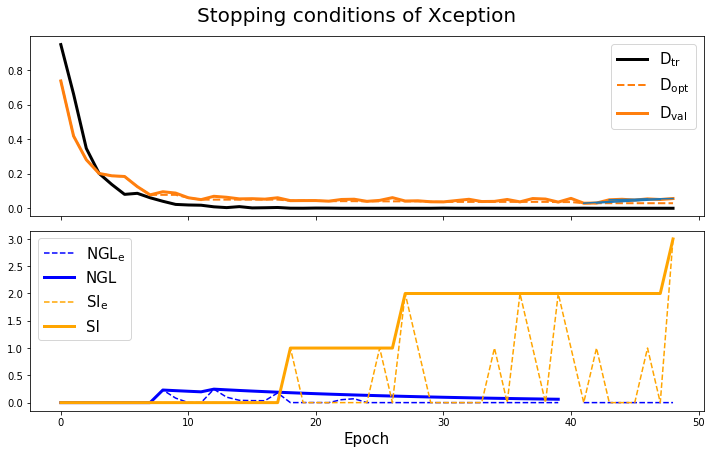

In [ ]:
#@title showPerformance
model_name = 'Xception' #@param
visualizeClass.showPerformance(model_name = model_name)

In [ ]:
#@title Tested OK
imageDatasets, dataloaders, dataset_sizes, class_names, dataset_dist = datasetClass.loadDataset()

mean, std = datasetClass.getNormalizeParameters()
datasetClass.show_augment(set = 'train', num_examples = 3, num_augments = 4)
datasetClass.show_augment(set = 'val', num_examples = 2, num_augments = 4)

datasetClass.testGetAndForward(model)

In [ ]:
# Disk storage
!df -h

In [ ]:
# CPU
!cat /proc/cpuinfo

In [ ]:
# RAM
!cat /proc/meminfo
#!cat /proc/meminfo | egrep “^MemTotal”

In [ ]:
# GPU & CUDA
!nvidia-smi -L
!nvidia-smi

2021-09-02 10:58:45,646 - modules.evaluation - loadValidationMetrics - DEBUG - [STTS] Loading validation metrics of model NASNet_A_Mobile at /content/drive/MyDrive/Thesis/logs/NASNet_A_Mobile/evaluation/validation_metrics.pt...
2021-09-02 10:58:45,657 - modules.evaluation - loadValidationMetrics - DEBUG - [STTS] Loading validation metrics of model ResNet50 at /content/drive/MyDrive/Thesis/logs/ResNet50/evaluation/validation_metrics.pt...
2021-09-02 10:58:45,664 - modules.evaluation - loadValidationMetrics - DEBUG - [STTS] Loading validation metrics of model Xception at /content/drive/MyDrive/Thesis/logs/Xception/evaluation/validation_metrics.pt...


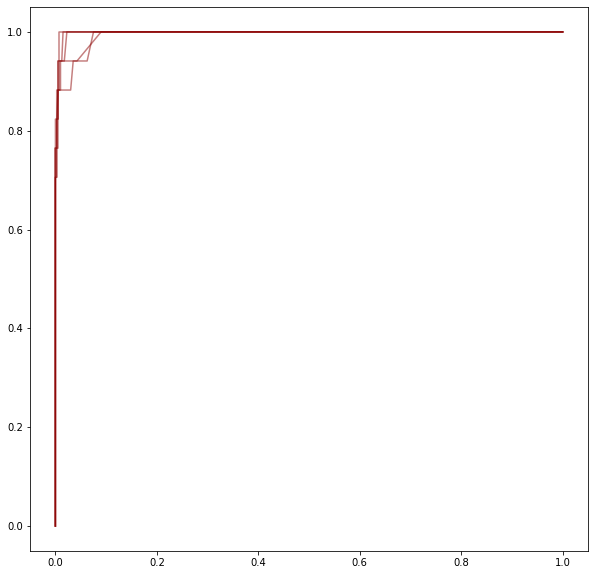

In [ ]:
val_NAS = evaluationClass.loadValidationMetrics(model_name = 'NASNet_A_Mobile')
val_Res = evaluationClass.loadValidationMetrics(model_name = 'ResNet50')
val_X = evaluationClass.loadValidationMetrics(model_name = 'Xception')

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (10, 10))
for i in range(5):
    # ax.plot(val_NAS['roc'][i, 0], val_NAS['roc'][i, 1], color = 'darkorange', alpha = 0.5)
    # ax.plot(val_Res['roc'][i, 0], val_Res['roc'][i, 1], color = 'darkblue', alpha = 0.5)
    ax.plot(val_X['roc'][i, 0], val_X['roc'][i, 1], color = 'darkred', alpha = 0.5)

In [ ]:
# Model inference
model_name = 'NASNet_A_Mobile'
candidate_ind = 2
model = modelClass.initModel(model_name = model_name)
model_state_dict = evaluationClass.loadCandidate(model_name, candidate_ind)
model.load_state_dict(model_state_dict)

2021-09-05 03:35:44,869 - modules.model - initModel - DEBUG - [CMPL] Initialized model NASNet_A_Mobile with 4235092 parameters, moved to cuda
2021-09-05 03:35:45,125 - modules.evaluation - loadCandidate - DEBUG - [CMPL] Load candidate 2 of model NASNet_A_Mobile


<All keys matched successfully>

In [ ]:
#@title def test
def test(model, model_name, candidate_ind, test_set):
    test_loader = torch.utils.data.DataLoader(
        dataset        = test_set,
        batch_size     = evaluationClass.batch_size,
        shuffle        = True,
        num_workers    = evaluationClass.num_workers,
        worker_init_fn = evaluationClass.worker_init_fn,
        generator      = evaluationClass.generator)
                                                
    test_predictions, test_labels = evaluationClass.doValidation(
        model      = model,
        loader     = test_loader,
        class_dist = test_set.getClassDistribution())
    
    # Re-find best threshold (again) with higher sampling
    candidate_metrics = {}
    candidate_metrics = evaluationClass.calculateROCPRC(
        predictions       = test_predictions,
        labels            = test_labels,
        candidate_metrics = candidate_metrics)

    # threshold_max_f1 = evaluationClass.loadValidationMetrics(model_name = model_name)['threshold_max_f1'][candidate_ind]
    
    candidate_metrics = evaluationClass.calculateOtherMetrics(
        predictions       = test_predictions,
        labels            = test_labels,
        threshold         = 0.2,
        candidate_metrics = candidate_metrics)
    
    # candidate_metrics['threshold_max_f1'] = threshold_max_f1
    
    return candidate_metrics

In [ ]:
candidate_metrics = test(model = model, model_name=None, candidate_ind=None, test_set=test_set)

  0%|          | 0/194 [00:00<?, ?batch/s]

In [ ]:
for key in candidate_metrics.keys():
    print(f'{key}: {candidate_metrics[key]}')

roc: tensor([[1.0000, 0.3023, 0.1713,  ..., 0.0000, 0.0000, 0.0000],
        [1.0000, 1.0000, 0.9900,  ..., 0.0000, 0.0000, 0.0000]])
auroc: 0.9964132905006409
prc: tensor([[1.0000, 1.0000, 0.9900,  ..., 0.0000, 0.0000, 0.0000],
        [0.0323, 0.0993, 0.1615,  ..., 1.0000, 1.0000, 1.0000]])
auprc: 0.9633423686027527
confusion_matrix: tensor([[  90,   10],
        [   7, 2993]])
accuracy: 0.994516134262085
precision: 0.9278350472450256
recall: 0.8999999761581421
specificity: 0.9976666569709778
f1_score: 0.9137055277824402


In [ ]:
a = torch.arange(501).type(torch.LongTensor)
thresholds = torch.linspace(start = -1e-7, end = 1+1e-7, steps = 501)
threshold_ind = a[candidate_metrics['prc'][0] >= 0.80].max()
print(threshold_ind)
print(thresholds[threshold_ind])

tensor(116)
tensor(0.2320)


In [ ]:
evaluationClass.loadValidationMetrics('Xception')

In [ ]:
#@title visTest
_, test_NAS = evaluationClass.test(
    modelClass = modelClass,
    model_name = 'NASNet_A_Mobile',
    candidate_ind = 2,              
    test_set = test_set)

_, test_Res = evaluationClass.test(
    modelClass = modelClass,
    model_name = 'ResNet50',
    candidate_ind = 0,              
    test_set = test_set)

_, test_X = evaluationClass.test(
    modelClass = modelClass,
    model_name = 'Xception',
    candidate_ind = 3,              
    test_set = test_set)

In [ ]:
#@title Test PRC
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def iso_f1(f1):
    # Recall
    x = torch.linspace(start = f1/2 + 1e-7, end = 2, steps = 101)
    # Precision
    y = f1*x / (2*x - f1)
    return x, y
for f1_score in [0.2, 0.4, 0.6, 0.8]:
    x, y = iso_f1(f1_score)
    ax.plot(x, y, color = 'tab:green', linestyle = 'dashed', linewidth = 2,)
    ax.text(f1_score-0.032, f1_score-0.032, f1_score, color = 'tab:green')

no_skill = test_set.class_dist['covid']/(test_set.class_dist['covid'] + test_set.class_dist['non'])
ax.axhline(y = no_skill, color = 'black', linewidth = 2, linestyle = 'dashed')

ax.plot(test_Res['prc'][0], test_Res['prc'][1], linewidth = 3, color = 'darkblue')
ax.plot(test_NAS['prc'][0], test_NAS['prc'][1], linewidth = 3, color = 'darkorange')
ax.plot(test_X['prc'][0], test_X['prc'][1], linewidth = 3, color = 'darkred')

ax.set_xlim(0, 1.02)
ax.set_ylim(0, 1.02)
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

legend_elements = [
    Line2D([0], [0], color='darkblue', linewidth = 3, label='ResNet50'),
    Line2D([0], [0], color='darkorange', linewidth = 3, label='NASNet_A_Mobile'),
    Line2D([0], [0], color='darkred', linewidth = 3, label='Xception'),
    Line2D([0], [0], color='white', linewidth = 3),
    Line2D([0], [0], color='tab:green', linewidth = 2, linestyle = 'dashed', label='Iso-F1 curves'),
    Line2D([0], [0], color='black', linewidth = 2, linestyle = 'dashed', label='No-skill ($\mathregular{3.23×{10}^{-2} }$)'),]
legend = ax.legend(handles = legend_elements, bbox_to_anchor = [0.5, 1, 0, 0], loc='lower center', ncol = 3, fontsize = 17)

plt.tight_layout()
plt.show(fig)

In [ ]:
#@title Test ROC
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

ax.plot([0, 1], [0, 1], color = 'black', linewidth = 2, linestyle = 'dashed')

ax.plot(test_Res['roc'][0], test_Res['roc'][1], linewidth = 3, color = 'darkblue')
ax.plot(test_NAS['roc'][0], test_NAS['roc'][1], linewidth = 3, color = 'darkorange')
ax.plot(test_X['roc'][0], test_X['roc'][1], linewidth = 3, color = 'darkred')

ax.set_xlim(-0.01, 1.01)
ax.set_ylim(-0.01, 1.01)
ax.set_ylabel('Recall')
ax.set_xlabel('Fall-out')

legend_elements = [
    Line2D([0], [0], color='darkblue', linewidth = 3, label='ResNet50'),
    Line2D([0], [0], color='darkorange', linewidth = 3, label='NASNet_A_Mobile'),
    Line2D([0], [0], color='darkred', linewidth = 3, label='Xception'),
    Line2D([0], [0], color='black', linewidth = 2, linestyle = 'dashed', label='No-skill'),]
legend = ax.legend(handles = legend_elements, bbox_to_anchor = [0.5, 1, 0, 0], loc='lower center', ncol = 2, fontsize = 17)

plt.tight_layout()
plt.show(fig)

In [120]:
# Load candidate
Xception = modelClass.initModel('Xception')
Xception_state_dict = evaluationClass.loadCandidate('Xception', 3)
Xception.load_state_dict(Xception_state_dict)

NASNet = modelClass.initModel('NASNet_A_Mobile')
NASNet_state_dict = evaluationClass.loadCandidate('NASNet_A_Mobile', 2)
NASNet.load_state_dict(NASNet_state_dict)

ResNet50 = modelClass.initModel('ResNet50')
ResNet50_state_dict = evaluationClass.loadCandidate('ResNet50', 0)
ResNet50.load_state_dict(ResNet50_state_dict)

2021-09-05 05:07:47,810 - modules.model - initModel - DEBUG - [CMPL] Initialized model Xception with 20811050 parameters, moved to cuda
2021-09-05 05:07:48,016 - modules.evaluation - loadCandidate - DEBUG - [CMPL] Load candidate 3 of model Xception
2021-09-05 05:07:48,291 - modules.model - initModel - DEBUG - [CMPL] Initialized model NASNet_A_Mobile with 4235092 parameters, moved to cuda
2021-09-05 05:07:48,587 - modules.evaluation - loadCandidate - DEBUG - [CMPL] Load candidate 2 of model NASNet_A_Mobile
2021-09-05 05:07:49,120 - modules.model - initModel - DEBUG - [CMPL] Initialized model ResNet50 with 23512130 parameters, moved to cuda
2021-09-05 05:07:49,353 - modules.evaluation - loadCandidate - DEBUG - [CMPL] Load candidate 0 of model ResNet50


<All keys matched successfully>

In [121]:
#@title testGetAndForward 
def testGetAndForward(self, subset, item_indices, model1, model2, model3, threshold1, threshold2, threshold3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    softmax = torch.nn.Softmax(dim = 1)
    num_examples = sum(subset.getClassDistribution())
    
    model1.eval()
    model2.eval()
    model3.eval()
    with torch.no_grad():
        for i, item_ind in enumerate(item_indices):
            item_test_flags = torch.zeros(3)
            # Get
            image, label = subset.__getitem__(item_ind)
            # Forward
            predictions1 = model1(image.unsqueeze(0).to(device))
            predictions2 = model2(image.unsqueeze(0).to(device))
            predictions3 = model3(image.unsqueeze(0).to(device))
            probability1 = softmax(predictions1)
            probability2 = softmax(predictions2)
            probability3 = softmax(predictions3)            

            if probability1[0, 1] >= threshold1: pred_class1 = 'cov'
            else: pred_class1 = 'non'

            if probability2[0, 1] >= threshold2: pred_class2 = 'cov'
            else: pred_class2 = 'non'

            if probability3[0, 1] >= threshold3: pred_class3 = 'cov'
            else: pred_class3 = 'non'

            print(f'I{item_ind},\tL{label},\t{probability1[0, 1] * 100:.2f}%\t{pred_class1},\t{probability2[0, 1] * 100:.2f}%,\t{pred_class2},\t{probability3[0, 1] * 100:.2f}%,\t{pred_class3}')
    self.logger.debug(f'[CMPL] Unit-tested __getitem__ and feedforward')

In [370]:
threshold = {
    'ResNet50': 0.0031,
    'NASNet_A_Mobile': 0.0265,
    'Xception': 0.00667
}

testGetAndForward(self = datasetClass,
                  subset = test_set,
                  item_indices = range(2700, 2800),
                  model1 = ResNet50,
                  model2 = NASNet,
                  model3 = Xception,
                  threshold1 = 0.0031,
                  threshold2 = 0.0265,
                  threshold3 = 0.00667)

I2700,	L0,	0.01%	non,	0.42%,	non,	0.01%,	non
I2701,	L0,	0.06%	non,	0.12%,	non,	0.32%,	non
I2702,	L0,	0.00%	non,	0.05%,	non,	0.36%,	non
I2703,	L0,	0.04%	non,	0.09%,	non,	0.05%,	non
I2704,	L0,	0.19%	non,	0.33%,	non,	0.91%,	cov
I2705,	L0,	0.01%	non,	0.02%,	non,	1.04%,	cov
I2706,	L0,	0.00%	non,	0.02%,	non,	0.00%,	non
I2707,	L0,	0.05%	non,	0.02%,	non,	0.30%,	non
I2708,	L0,	0.01%	non,	0.04%,	non,	0.05%,	non
I2709,	L0,	0.00%	non,	0.03%,	non,	0.09%,	non
I2710,	L0,	0.00%	non,	0.02%,	non,	0.00%,	non
I2711,	L0,	0.01%	non,	0.05%,	non,	0.10%,	non
I2712,	L0,	0.00%	non,	0.04%,	non,	0.12%,	non
I2713,	L0,	0.02%	non,	0.06%,	non,	0.02%,	non
I2714,	L0,	0.02%	non,	0.04%,	non,	1.47%,	cov
I2715,	L0,	0.00%	non,	0.17%,	non,	0.01%,	non
I2716,	L0,	0.02%	non,	0.07%,	non,	0.03%,	non
I2717,	L0,	0.02%	non,	0.12%,	non,	0.00%,	non
I2718,	L0,	0.02%	non,	0.02%,	non,	0.04%,	non
I2719,	L0,	0.06%	non,	1.31%,	non,	0.11%,	non
I2720,	L0,	0.01%	non,	0.30%,	non,	0.16%,	non
I2721,	L0,	0.01%	non,	0.03%,	non,	0.06%,	non
I2722,	L0,

2021-09-05 07:22:28,658 - modules.dsets - testGetAndForward - DEBUG - [CMPL] Unit-tested __getitem__ and feedforward


I2797,	L0,	0.00%	non,	0.43%,	non,	0.23%,	non
I2798,	L0,	0.00%	non,	0.13%,	non,	0.10%,	non
I2799,	L0,	1.10%	cov,	1.19%,	non,	0.69%,	cov


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


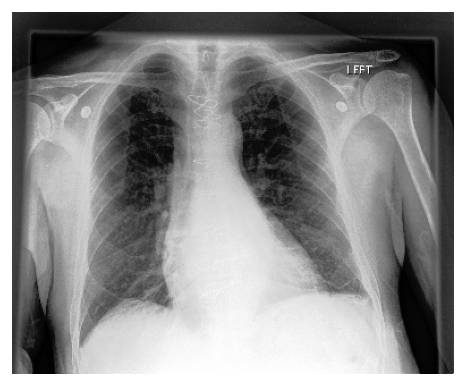

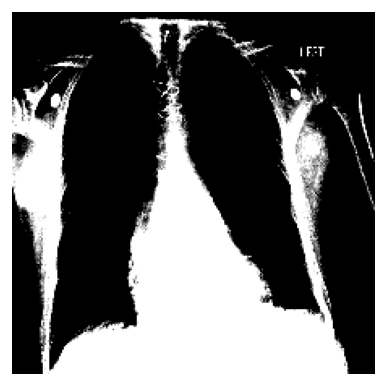

In [373]:
item_ind =  2799#@param
image, label = test_set.getRawItem(item_ind)
image2, _ = test_set.__getitem__(item_ind)

fig, ax = plt.subplots(dpi = 120)
ax.imshow(image.permute(1, 2, 0))
ax.set_axis_off()

fig2, ax2 = plt.subplots(dpi = 120)
ax2.imshow(image2.permute(1, 2, 0))
ax2.set_axis_off()

plt.show(fig)
plt.show(fig2)